# Simulation of twisted bilayer graphene close to magic angle

## Import modules

In [1]:
import sys 
import os

import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

from pybandstructure import *

## Set parameters
Notation follows arXiv:2005.09529 

In [2]:
#################### graphene parameters #######################################
#distances in nm, energies in eV
a = 0.142 * np.sqrt(3) #[nm] lattice constant of graphene
hv = 0.57 #hbar v_D [eV*nm]

Pietro = False ##select Pietro parameters
if Pietro:
    theta = 1.05 #twist angle [deg]
    u0 = 0.0797 #AA interlayer coupling
    u1 = 0.0975 #AB interlayer coupling
    density = 0. #electron density in [nm^-2]
    temperature = 0.0004 #k_BT in eV
else:
    theta = 1.35 #twist angle [deg]
    u0 = 0.#0.0797 #AA interlayer coupling
    u1 = 0.#.0.0975 #AB interlayer coupling
    density = 0. #electron density in [nm^-2]
    temperature = 0.026 #k_BT in eV
#################### computational parameters ##################################
n_sites = 36 # number of unit cells of the crystal in one direction !must be multiple of 6!
G_max = 3 #number of shells considered in reciprocal space
n_bands = 5 #number of bands calculated below and above Dirac point
eta = 0.005 #energy smoothing [eV]
####################### Output folder ##########################################
output_folder = 'test_output'
file_name = 'tblg'
################################################################################

## Define crystal geometry and sampling

In [3]:
#lenght of reciprocal lattice vectors
G = 8. * np.pi * np.sin(theta / 360. * np.pi)/ (np.sqrt(3) * a)
#special points
Mxy = int(n_sites/2)
Kxy = int(n_sites/3)

special_points = {'$\Gamma$': (0, 0), '$M$': (Mxy, 0), '$M^\prime$': (0, Mxy), '$K$': (Kxy, Kxy)}



#define reciprocal lattice basis
reciprocal_lattice_basis = G * np.array([[          0.5,         -0.5],
                                         [np.sqrt(3)/2.,np.sqrt(3)/2.]], dtype = float)
#select point group (D3 in general for TBLG, D6 if u_0 = 0)
point_group = Point_Group.dihedral_group(n=6, theta0 = np.arctan2(reciprocal_lattice_basis[1,0], 
              reciprocal_lattice_basis[0,0]))

#point_group = Point_Group.trivial_group(space_dimension=2)
#defines lattice geometry given Bravais lattice 
lattice_geometry = Crystal_Geometry(reciprocal_lattice_basis = reciprocal_lattice_basis, 
                                    point_group = point_group)
#sampling of reciprocal lattice
reciprocal_lattice_vectors = Sample.lattice_sample(basis_vectors=reciprocal_lattice_basis, cut_off=G * G_max)
G_sample = Sample.lattice_sample(basis_vectors=reciprocal_lattice_basis, cut_off=G *0.)


#sampling of BZ
k_sample = Unit_Cell_Sample.irreducible_sample(name = '2D_Hexagonal_D3_Axes',
                                               basis_vectors= reciprocal_lattice_basis, 
                                               denominator=n_sites)
q_sample = Unit_Cell_Sample.wigner_seitz_cell(basis_vectors= reciprocal_lattice_basis, 
                                               denominator=n_sites, special_points=special_points)

## Plot reciprocal lattice and Brillouin zone sampling

..\pybandstructure\sample\sample.py:584: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
..\pybandstructure\sample\sample.py:584: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


Text(0, 0.5, '$k_y\\,[{\\rm nm^{-1}}]$')

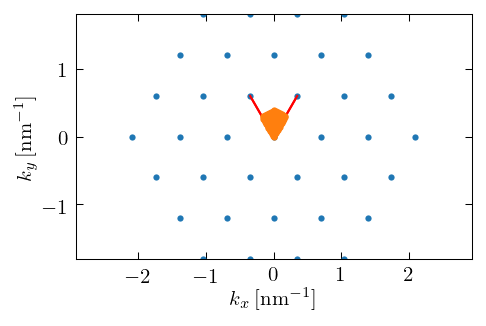

In [4]:
plt.xlim(-G * G_max,G * G_max)
plt.ylim(-G * G_max,G * G_max)
reciprocal_lattice_vectors.plot()
k_sample.plot()

plt.xlabel(r'$k_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$k_y\,[{\rm nm^{-1}}]$')

## TBLG hamiltonian (Koshino model)

In [5]:
############################## intra-layer Hamiltonian #########################
#kinetic_matrix = [np.kron(pauli_matrix('u'),pauli_matrix('x')),np.kron(pauli_matrix('u'),pauli_matrix('y')),
#                  np.kron(pauli_matrix('l'),pauli_matrix('x')),np.kron(pauli_matrix('l'),pauli_matrix('y'))]
# sign in front of \sigma_x
kinetic_matrix = [np.kron(pauli_matrix('u'),-pauli_matrix('x')),np.kron(pauli_matrix('u'),pauli_matrix('y')),
                  np.kron(pauli_matrix('l'),-pauli_matrix('x')),np.kron(pauli_matrix('l'),pauli_matrix('y'))]
class kinetic_function():
    def __init__(self, theta, G , hv, der = (0,0)):
        self.theta = theta
        self.G = G
        self.hv = hv
        self.der = der
        
        s = np.sin(self.theta / 360. *np.pi)
        c = np.cos(self.theta / 360. *np.pi)
        #self.R1 = np.array([[c, -s],[s,c]])
        #self.R2 = np.array([[c, s], [-s,c]])
        #sign of rotation
        self.R1 = np.array([[c, s],[-s,c]])
        self.R2 = np.array([[c, -s], [s,c]])
        #self.K1 = self.G / np.sqrt(3) * np.array([-np.sqrt(3)/2,0.5])
        #self.K2 = self.G / np.sqrt(3) * np.array([-np.sqrt(3)/2,-0.5])
        #definition of K_l
        self.K1 = self.G / np.sqrt(3) * np.array([np.sqrt(3)/2,0.5])
        self.K2 = self.G / np.sqrt(3) * np.array([np.sqrt(3)/2,-0.5])
    def __call__(self, k):
        if self.der == (0,0):
            return self.hv * np.concatenate((np.dot(self.R1, k - self.K1), np.dot(self.R2, k - self.K2)) )
        elif self.der == (1,0):
            return self.hv * np.concatenate((np.dot(self.R1, np.array([1.,0.])), np.dot(self.R2,np.array([1.,0.]))) )
        elif self.der == (0,1):
            return self.hv * np.concatenate((np.dot(self.R1,np.array([0.,1.])), np.dot(self.R2,np.array([0.,1.]))) )
        else:
            return 0.
    
H0 = Momentum_Conserving_Operator(matrices = [kinetic_matrix],
                                  coefficients = [kinetic_function(theta = theta, G = G, hv = hv)],
                                  collapse = True)

H0_lattice = build_kinetic_hamiltonian(H0, 
                                       reciprocal_lattice_vectors = reciprocal_lattice_vectors)
########################## Momentum operators ##################################

p_x = build_kinetic_term(kinetic_matrix, 
                           kinetic_function(theta,G=G, hv=hv,der=(1,0)), 
                           reciprocal_lattice_vectors = reciprocal_lattice_vectors)
p_y = build_kinetic_term(kinetic_matrix, 
                           kinetic_function(theta,G=G, hv=hv,der=(0,1)), 
                           reciprocal_lattice_vectors = reciprocal_lattice_vectors)

############################## AA tunneling Hamiltonian ########################

#const = np.exp(-1j*2*np.pi/3) #now agrees with the paper
const = np.exp(1j*2*np.pi/3)
AA_coupling_plus = np.zeros([len(reciprocal_lattice_vectors)], dtype = complex)
AA_coupling_minus = np.zeros([len(reciprocal_lattice_vectors)], dtype = complex)
AA_coupling_plus[reciprocal_lattice_vectors[(0,0)]] = u0
AA_coupling_plus[reciprocal_lattice_vectors[(1,0)]] = u0 / const
AA_coupling_plus[reciprocal_lattice_vectors[(0,1)]] = u0 * const
AA_coupling_minus[reciprocal_lattice_vectors[(0,0)]] = u0
AA_coupling_minus[reciprocal_lattice_vectors[(-1,0)]] = u0 * const
AA_coupling_minus[reciprocal_lattice_vectors[(0,-1)]] = u0 / const

H_AA_plus = build_potential_hamiltonian(U = np.kron(pauli_matrix('+'), pauli_matrix('I')), 
                                        potential_components = AA_coupling_plus, 
                                        reciprocal_lattice_vectors = reciprocal_lattice_vectors)
H_AA_minus = build_potential_hamiltonian(U = np.kron(pauli_matrix('-'), pauli_matrix('I')), 
                                        potential_components = AA_coupling_minus, 
                                        reciprocal_lattice_vectors = reciprocal_lattice_vectors)
H_AA = H_AA_plus + H_AA_minus

H_AA.collapse_constant_coefficients()

############################## AB tunneling Hamiltonian ########################

AB_coupling_plus_plus = np.zeros([len(reciprocal_lattice_vectors)], dtype = complex)
AB_coupling_plus_minus = np.zeros([len(reciprocal_lattice_vectors)], dtype = complex)
AB_coupling_minus_plus = np.zeros([len(reciprocal_lattice_vectors)], dtype = complex)
AB_coupling_minus_minus = np.zeros([len(reciprocal_lattice_vectors)], dtype = complex)

AB_coupling_plus_plus[reciprocal_lattice_vectors[(0,0)]] = u1
AB_coupling_plus_plus[reciprocal_lattice_vectors[(1,0)]] = u1
AB_coupling_plus_plus[reciprocal_lattice_vectors[(0,1)]] = u1

AB_coupling_plus_minus[reciprocal_lattice_vectors[(0,0)]] = u1
AB_coupling_plus_minus[reciprocal_lattice_vectors[(1,0)]] = u1 * const
AB_coupling_plus_minus[reciprocal_lattice_vectors[(0,1)]] = u1 / const

AB_coupling_minus_minus[reciprocal_lattice_vectors[(0,0)]] = u1
AB_coupling_minus_minus[reciprocal_lattice_vectors[(-1,0)]] = u1
AB_coupling_minus_minus[reciprocal_lattice_vectors[(0,-1)]] = u1

AB_coupling_minus_plus[reciprocal_lattice_vectors[(0,0)]] = u1
AB_coupling_minus_plus[reciprocal_lattice_vectors[(-1,0)]] = u1 / const
AB_coupling_minus_plus[reciprocal_lattice_vectors[(0,-1)]] = u1 * const

H_AB_plus_plus = build_potential_hamiltonian(U = np.kron(pauli_matrix('+'),pauli_matrix('+')), 
                                             potential_components = AB_coupling_plus_plus, 
                                             reciprocal_lattice_vectors = reciprocal_lattice_vectors)
H_AB_plus_minus = build_potential_hamiltonian(U = np.kron(pauli_matrix('+'),pauli_matrix('-')), 
                                              potential_components = AB_coupling_plus_minus, 
                                              reciprocal_lattice_vectors = reciprocal_lattice_vectors)
H_AB_minus_minus = build_potential_hamiltonian(U = np.kron(pauli_matrix('-'),pauli_matrix('-')), 
                                               potential_components = AB_coupling_minus_minus, 
                                               reciprocal_lattice_vectors = reciprocal_lattice_vectors)
H_AB_minus_plus = build_potential_hamiltonian(U = np.kron(pauli_matrix('-'), pauli_matrix('+')), 
                                              potential_components = AB_coupling_minus_plus, 
                                              reciprocal_lattice_vectors = reciprocal_lattice_vectors)
H_AB = H_AB_plus_plus + H_AB_minus_minus + H_AB_plus_minus + H_AB_minus_plus
H_AB.collapse_constant_coefficients()

####################### Total Hamiltonian ######################################

H = H0_lattice + H_AB + H_AA
H.collapse_constant_coefficients()

## Calculate band structure

In [6]:
####################### Output folder ##################################
output_folder = 'test_output/tblg'
file_name = '/tblg.hdf5'
########################################################################
########################################################################
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
try:
    os.remove(output_folder + file_name)
except:
    pass
band_structure = Band_Structure.from_hamiltonian(k_sample = k_sample,
                                                 q_sample = q_sample,
                                                 G_sample = G_sample,
                                                 hamiltonian = H , momentum_operator= [p_x,p_y],
                                                 degeneracy = 4,
                                                 zero_filling = n_bands,
                                                 density = density,
                                                 temperature = temperature)

band_structure.compute_bands(eigvals = (4 * len(reciprocal_lattice_vectors) // 2 - n_bands,
                        4 * len(reciprocal_lattice_vectors) // 2 + n_bands - 1))   
band_structure.compute_momentum_matrix()
band_structure.save(file_name = output_folder + file_name, band_structure_name = 'band_structure')
tblg = Crystal(geometry = lattice_geometry,
                   band_structure=band_structure, eta = eta)

100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 23.82it/s]


## Plot one band in the Brillouin zone

(10, 235)


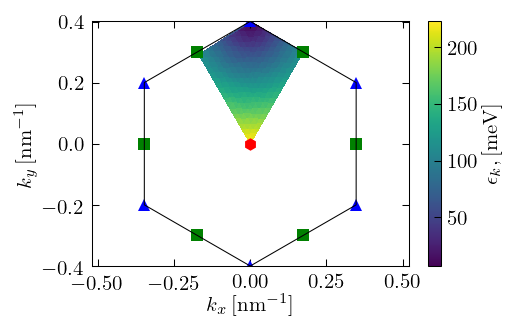

In [7]:
nu= n_bands
################################################################################
plt.figure()
plt.axes()
plt.axis('equal')
plt.xlabel(r'$k_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$k_y\,[{\rm nm^{-1}}]$')
plt.xlim(-G/2,G/2)
plt.ylim(-np.sqrt(3)*G/3,np.sqrt(3)*G/3)
#M-points
plt.plot(G/2,0,'gs',ms=6)
plt.plot(-G/2,0,'gs',ms=6)
plt.plot(0,G*np.sqrt(3)/2,'gs',ms=6)
plt.plot(0,-G*np.sqrt(3)/2,'gs',ms=6)

plt.plot(G/4,G*np.sqrt(3)/4,'gs',ms=6)
plt.plot(-G/4,G*np.sqrt(3)/4,'gs',ms=6)

plt.plot(G/4,-G*np.sqrt(3)/4,'gs',ms=6)
plt.plot(-G/4,-G*np.sqrt(3)/4,'gs',ms=6)
plt.plot(G/4,G*np.sqrt(3)*3/4,'gs',ms=6)
plt.plot(-G/4,G*np.sqrt(3)*3/4,'gs',ms=6)

#Gamma-points
plt.plot(0,0,'rh',ms=6)


#K-points
plt.plot(0,G/np.sqrt(3),'b^',ms=6)
plt.plot(G/2,G/(2 *np.sqrt(3)),'b^',ms=6)
plt.plot(G/2,-G/(2 *np.sqrt(3)),'b^',ms=6)
plt.plot(0,-G/np.sqrt(3),'b^',ms=6)
plt.plot(-G/2,-G/(2 *np.sqrt(3)),'b^',ms=6)
plt.plot(-G/2,G/(2 *np.sqrt(3)),'b^',ms=6)

plt.plot([0,G/2,G/2,0,-G/2,-G/2,0],
         [G/np.sqrt(3),G/(2 *np.sqrt(3)),-G/(2 *np.sqrt(3)),-G/np.sqrt(3),-G/(2 *np.sqrt(3)),G/(2 *np.sqrt(3)),G/np.sqrt(3)],
         c='k', lw=0.5)


plt.tripcolor(tblg.band_structure.k_sample.coords[:,0],  tblg.band_structure.k_sample.coords[:,1],
              1e3* tblg.band_structure.energies[nu,:])
cb = plt.colorbar()
cb.set_label(r'$\epsilon_k,[\rm meV]$'.format(nu-n_bands))
plt.savefig(output_folder +'/single_band.pdf')
print(tblg.band_structure.energies.shape)

## Make band plot along high symmetry contour

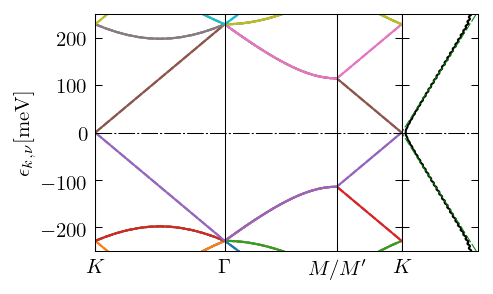

In [8]:
e_lims = -0.25,0.25 #energy limits for the figure
e_vals = np.linspace(*e_lims,num=250)

contour = tblg.band_structure.k_sample.contour([r'$K$', r'$\Gamma$', r'$M$', r'$K$'])
contour2 = tblg.band_structure.k_sample.contour([r'$K$', r'$\Gamma$', r'$M^\prime$', r'$K$'])
dosvals = tblg.dos(e_vals) #total dos by summing over band-resolved dos
################################################################################
#figure
plt.figure()
plt.axes([0.2,0.2,0.6,0.75])
#band plot
for i in range(2*n_bands):
    p = plt.plot(contour['x'],1e3*tblg.band_structure.energies[i,contour['indices']])
    plt.plot(contour['x'],1e3*tblg.band_structure.energies[i,contour2['indices']],'--', color = p[0].get_color())
#chemical potential
plt.plot([contour['x'][0],contour['x'][-1]],[tblg.band_structure.chemical_potential,tblg.band_structure.chemical_potential],'-.',c='k', lw=0.5)
#axes and limits
for point in contour['vertices']:
    plt.plot([contour['x'][point],contour['x'][point]],[1e3*e_vals[0],1e3*e_vals[-1]],lw=0.5, c='k')
#plt.plot([np.sqrt(3)/3+0.5,np.sqrt(3)/3+0.5],[1e3*e_vals[0],1e3*e_vals[-1]],lw=0.5, c='k')
plt.ylim(1e3*e_lims[0],1e3*e_lims[-1])
plt.ylabel(r'$\epsilon_{ k,\nu} [\rm meV]$')
plt.xticks(contour['x'][contour['vertices']],[r'$K$', r'$\Gamma$', r'$M/M^\prime$', r'$K$'])

#dos panel
ax = plt.axes([0.8,0.2,0.15,0.75])
ax.yaxis.set_label_position("right")
ax.set_xticks([])
ax.set_yticklabels([])
plt.ylim(1e3*e_lims[0],1e3*e_lims[-1])
plt.xlim(0,1.1*np.amax(dosvals)*1e-3)
plt.plot(1e-3*dosvals ,1e3*e_vals, c='k')
plt.plot(1e-3*abs(e_vals)*4/(np.pi * hv**2),1e3*e_vals,'--', c='g', lw=0.5)
plt.plot([0,1.1*np.amax(dosvals)*1e-3],[tblg.band_structure.chemical_potential,tblg.band_structure.chemical_potential],'-.',c='k', lw=0.5)

plt.savefig(output_folder +'/bands.pdf')

## Calculate optical and thermoelectric properties

In [9]:
omega_vals = np.linspace(0,0.3, num = 100)
sigma_vals = tblg.local_conductivity(omega_vals)[:,0,0]
mu_vals = np.linspace(-0.3,0.3, num = 100)
density_vals = np.array([tblg.band_structure.compute_density(chemical_potential = mu,temperature=tblg.band_structure.temperature) for mu in mu_vals])

W0 = tblg.generalized_drude_weight(chemical_potential = mu_vals,exponent=0)[:,0,0]
W1 = tblg.generalized_drude_weight(chemical_potential = mu_vals,exponent=1)[:,0,0]
W2 = tblg.generalized_drude_weight(chemical_potential = mu_vals,exponent=2)[:,0,0]

lorentz_number = 3./(np.pi**2* tblg.band_structure.temperature**2)*W2/W0
seebeck = -W1/(W0 * tblg.band_structure.temperature)

..\pybandstructure\crystal\analysis\conductivity_functions.py:8: RuntimeWarning: invalid value encountered in true_divide
  prefactor = -occupation_diff / energy_diff


## Plot density as function of chemical potential
Green dashed line is twice the density for single layer

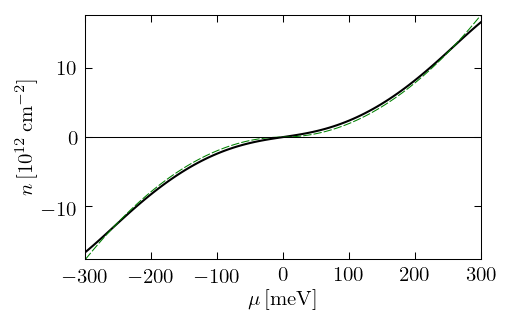

In [10]:
plt.xlabel(r'$\mu \, [{\rm meV}]$')
plt.ylabel(r'$n\,[10^{12} \,{\rm cm^{-2}}]$')


plt.plot(1e3*mu_vals,1e2*density_vals,'k-')
plt.plot(1e3*mu_vals,1e2*mu_vals**2 * np.sign(mu_vals) *2 /(np.pi * hv**2),'g--',lw=0.5)
plt.plot(1e3*mu_vals,np.zeros_like(mu_vals),'k-',lw=0.5)
plt.savefig(output_folder +'/density.pdf')

## Plot optical conductivity
In units of the conductance quantum $G_0= 2e^2/h$.
Real part as solid line, imaginary as dashed line.
Green dashed line is twice the real part of undoped graphene conductivity.

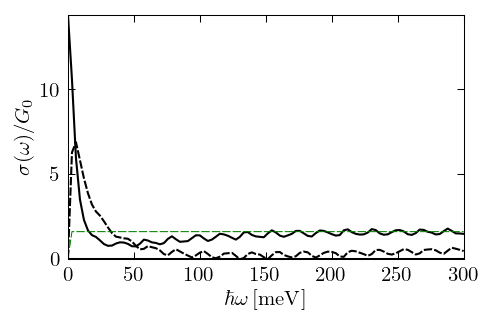

In [11]:
plt.xlabel(r'$\hbar \omega \, [{\rm meV}]$')
plt.ylabel(r'$\sigma(\omega)/G_0$')

plt.plot(1e3*omega_vals,np.real(sigma_vals),c='k')
plt.plot(1e3*omega_vals,np.imag(sigma_vals),'--',c='k')
plt.plot(1e3*omega_vals,np.heaviside(omega_vals-2*abs(tblg.band_structure.chemical_potential),0.5)*np.pi/2,'--', c='g', lw=0.5)
plt.plot(1e3*omega_vals,np.zeros_like(omega_vals),'k-',lw=0.5)
plt.savefig(output_folder +'/conductivity.pdf')

## Plot Drude weight as a function of chemical potential
Green dashed line is twice the Drude weight of single layer graphene at zero temperature 

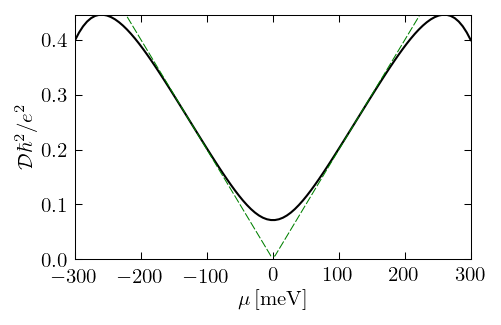

In [12]:
plt.xlabel(r'$\mu \, [{\rm meV}]$')
plt.ylabel(r'${\cal D}\hbar^2/e^2$')
plt.ylim(0,np.amax(W0))

plt.plot(1e3*mu_vals,W0,'k-')
plt.plot(1e3*mu_vals,abs(mu_vals)*2,'g--',lw=0.5)
plt.savefig(output_folder +'/drude.pdf')

## Plot Seebeck coefficient as a function of chemical potential
Black solid line is the full calculation, black dashed is the Mott formula.
Green dashed line is twice the Seebeck coefficient of single layer graphene at zero temperature 

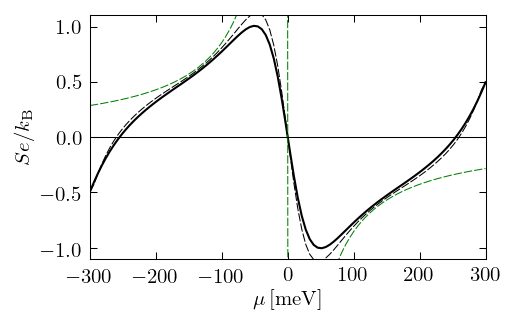

In [13]:
plt.xlabel(r'$\mu \, [{\rm meV}]$')
plt.ylabel(r'$Se/k_{\rm B}$')
plt.ylim(-np.amax(seebeck)*1.1,np.amax(seebeck)*1.1)

plt.plot(1e3*mu_vals,seebeck,'k-')
plt.plot(1e3*mu_vals,-np.pi**2/3 * tblg.band_structure.temperature*np.gradient(W0,mu_vals)/W0,'k--',lw=0.5)
plt.plot(1e3*mu_vals,-np.pi**2/3 * tblg.band_structure.temperature/mu_vals,'g--',lw=0.5)
plt.plot(1e3*mu_vals,np.zeros_like(mu_vals),'k-',lw=0.5)
plt.savefig(output_folder +'/seebeck.pdf')

## Lorentz number and violation of Wiedmann-Franz law
Plot of the effective Lorentz number ${\cal L} \equiv k/(\sigma T)$ divided by its nominal value ${\cal L}_0 \equiv \pi^2 k_{\rm B}^2/(3e^2)$.
The green line is the  Wiedmann-Franz prediction, i.e. ${\cal L}={\cal L}_0$.

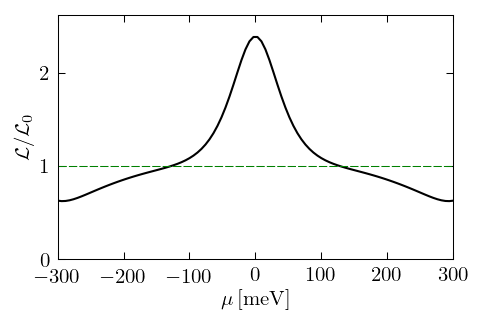

In [14]:
plt.ylabel(r'${\cal L}/{\cal L}_0$')
plt.xlabel(r'$\mu \, [{\rm meV}]$')
plt.ylim(0,np.amax(lorentz_number)*1.1)

plt.plot(1e3*mu_vals, lorentz_number, 'k-')
plt.plot(1e3*mu_vals, np.ones_like(mu_vals),'g--',lw=0.5)
plt.savefig(output_folder +'/lorentz.pdf')